# Training a StarDist model with TissueNet

In [1]:
import os
import sys

import numpy as np
from tqdm import tqdm

import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

## Load the training data

In [2]:
# File paths for data and models
NPZ_NAME = '20201018_multiplex_seed_3'
EXP_NAME = '20200824_hyper_parameter'
MODEL_NAME = '{}_deep_watershed'.format(NPZ_NAME)

ROOT_DIR = '/data'
LOG_DIR = os.path.join(ROOT_DIR, 'logs')
MODEL_DIR = os.path.join(ROOT_DIR, 'models', EXP_NAME)

DATA_DIR = os.path.join(ROOT_DIR, 'users/willgraf/mesmer_retrain')

TRAIN_DATA_FILE = os.path.join(DATA_DIR, '{}_train_512x512.npz'.format(NPZ_NAME))
VAL_DATA_FILE = os.path.join(DATA_DIR, '{}_val_256x256.npz'.format(NPZ_NAME))
TEST_DATA_FILE = os.path.join(DATA_DIR, '{}_test_256x256.npz'.format(NPZ_NAME))

TEST_PRED_DATA_FILE = os.path.join(DATA_DIR, '{}_test_pred.npz'.format(NPZ_NAME))

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
train_data = np.load(os.path.join(DATA_DIR, TRAIN_DATA_FILE), allow_pickle=True)
val_data = np.load(os.path.join(DATA_DIR, VAL_DATA_FILE), allow_pickle=True)
test_data = np.load(os.path.join(DATA_DIR, TEST_DATA_FILE), allow_pickle=True)

X_train = train_data['X']
y_train = train_data['y']

X_val = val_data['X']
y_val = val_data['y']

X_test = test_data['X']
y_test = test_data['y']

In [4]:
y_train = y_train.astype('int32').squeeze()
y_val = y_val.astype('int32').squeeze()
y_test = y_test.astype('int32').squeeze()

Normalize images and fill small label holes.

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly

n_channel = 1 if X_train[0].ndim == 2 else X_train[0].shape[-1]

if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X_train = [normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X_train)]
y_train = [fill_label_holes(y) for y in tqdm(y_train)]

X_val = [normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X_val)]
y_val = [fill_label_holes(y) for y in tqdm(y_val)]

X_test = [normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X_test)]
y_test = [fill_label_holes(y) for y in tqdm(y_test)]

Normalizing image channels independently.


100%|██████████| 1256/1256 [00:22<00:00, 56.02it/s]


## Estimate number of rays

from the `stardist` [example data notebook](https://github.com/stardist/stardist/blob/master/examples/2D/1_data.ipynb).

The default value of `32` works well for TissueNet, no need to run below code.

In [ ]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in y_train.squeeze()]
    mean_iou = matching_dataset(y_train.squeeze(), Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

## Train a model

from the `stardist` [example training notebook](https://github.com/stardist/stardist/blob/master/examples/2D/2_training.ipynb)

In [6]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2, 2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = 2,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=2, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 2), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 2,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 2),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [7]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [8]:
model = StarDist2D(conf, name='stardist', basedir='models')

base_model.py (148): output path for model already exists, files may be overwritten: /notebooks/models/stardist


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.48301, nms_thresh=0.3.


In [9]:
median_size = calculate_extents(list(y_train), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [22. 23.]
network field of view :  [92 94]


### Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.
We here use an augmenter that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting augmenter = None).

In [10]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [11]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

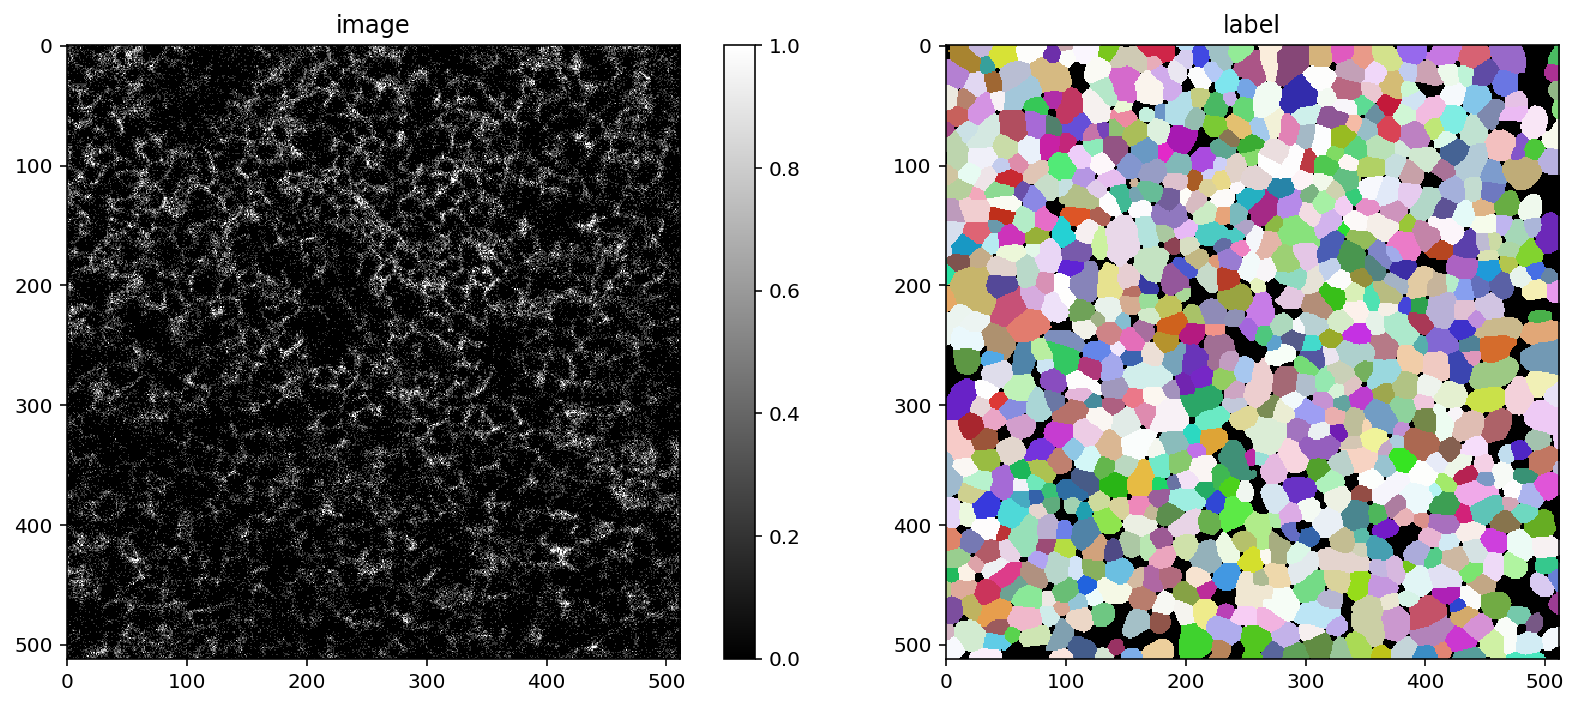

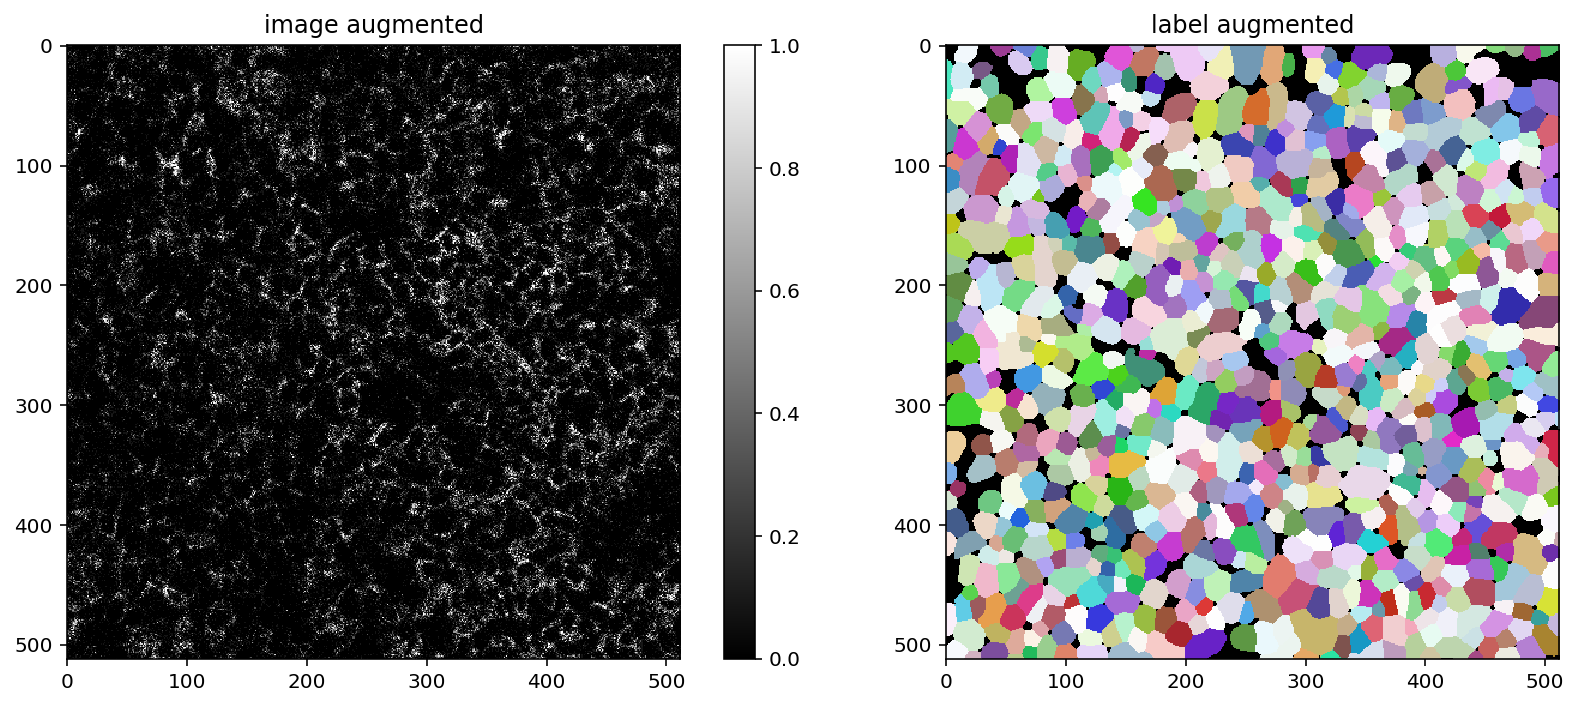

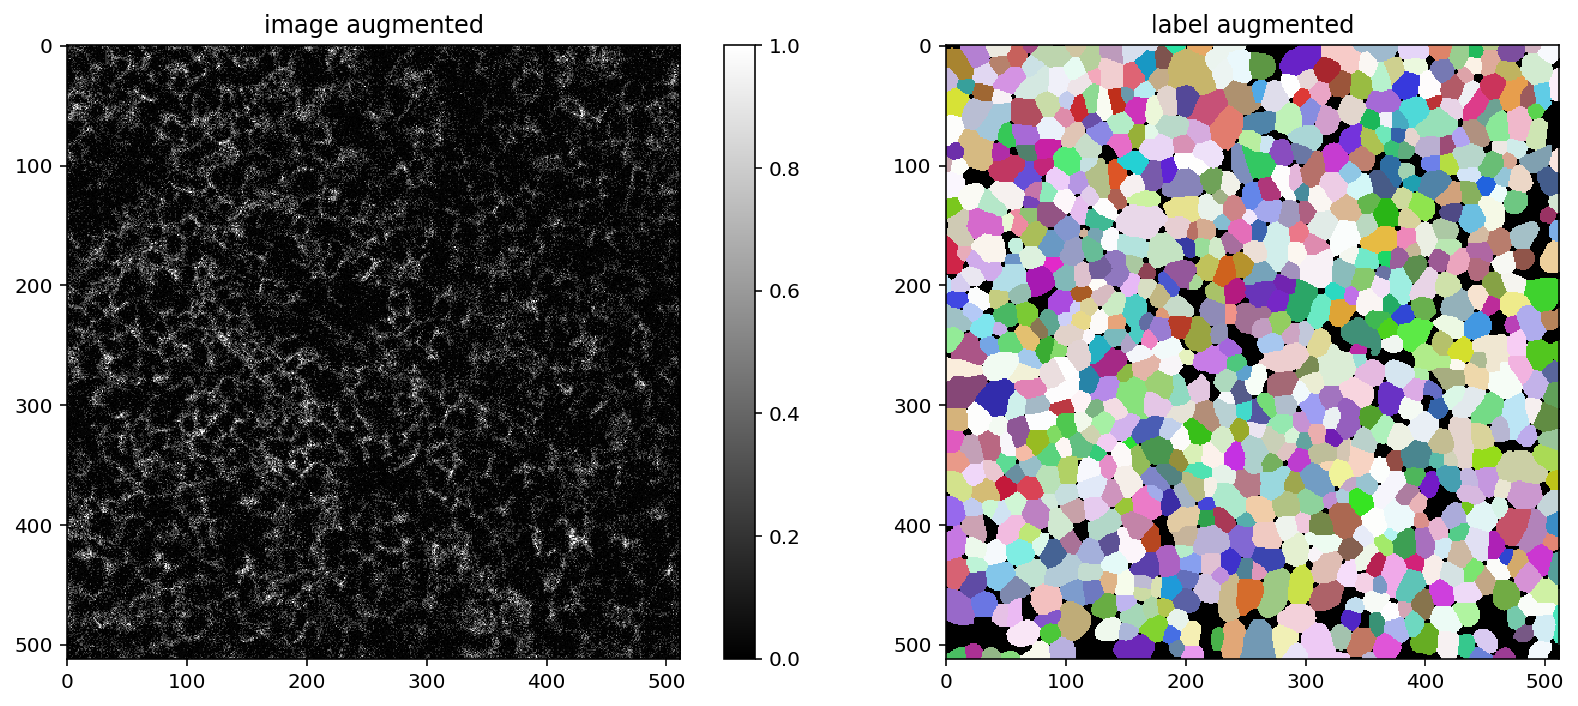

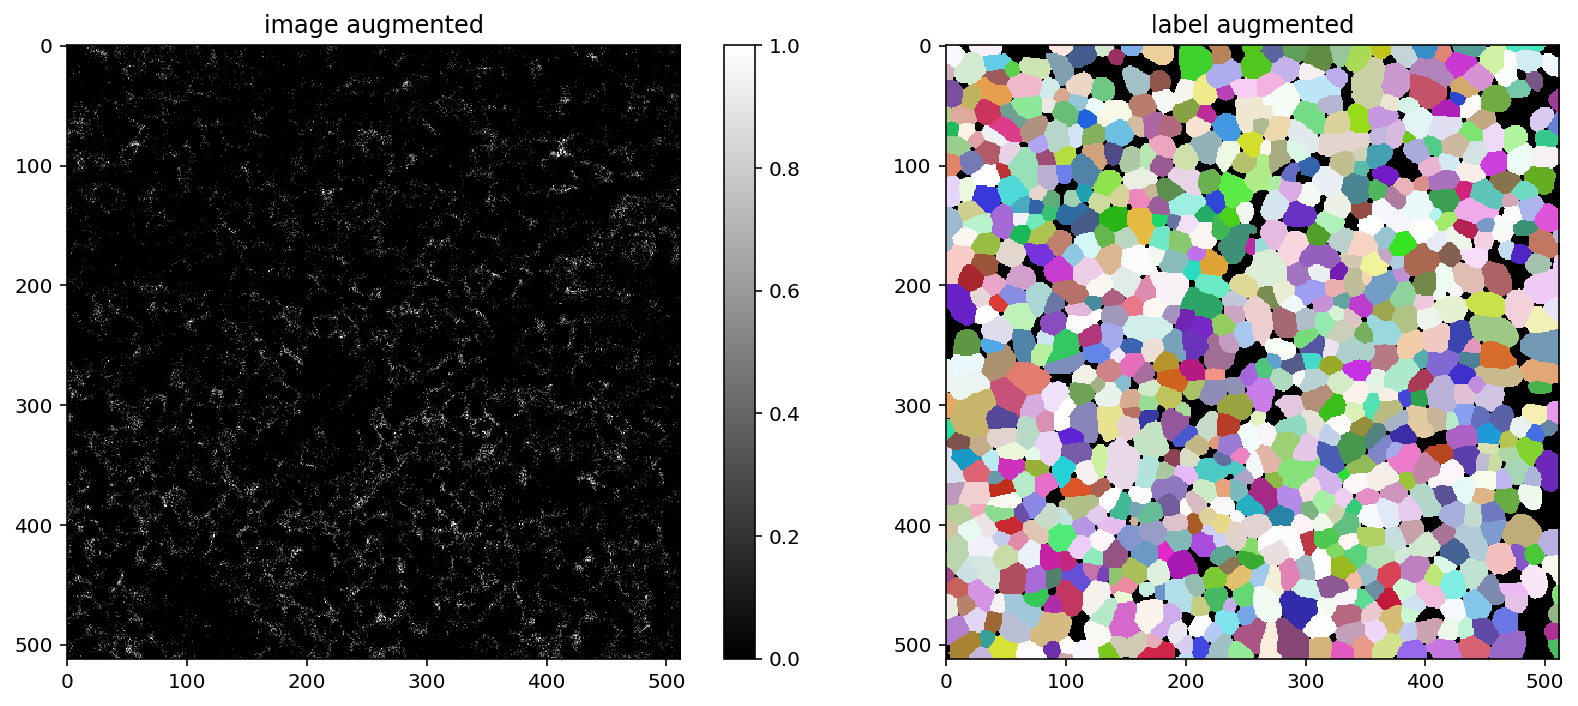

In [12]:
# plot some augmented examples
img, lbl = X_train[0], y_train[0]
plot_img_label(img[..., 1].astype('float'), lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug[..., 1].astype('float'), lbl_aug,
                   img_title="image augmented", lbl_title="label augmented")

## Training

We recommend to monitor the progress during training with TensorBoard. You can start it in the shell from the current working directory like this:

$ tensorboard --logdir=.

Then connect to http://localhost:6006/ with your browser.

In [13]:
model.train(X_train, y_train, validation_data=(X_val, y_val), augmenter=augmenter)

Epoch 1/400
100/100 [==============================] - 39s 364ms/step - loss: 2.4642 - prob_loss: 0.6346 - dist_loss: 9.1481 - prob_kld: 0.3307 - dist_relevant_mae: 9.1479 - dist_relevant_mse: 130.1066 - val_loss: 1.7071 - val_prob_loss: 0.5341 - val_dist_loss: 5.8650 - val_prob_kld: 0.3050 - val_dist_relevant_mae: 5.8645 - val_dist_relevant_mse: 72.4899
Epoch 2/400
100/100 [==============================] - 28s 286ms/step - loss: 1.6399 - prob_loss: 0.5484 - dist_loss: 5.4575 - prob_kld: 0.2448 - dist_relevant_mae: 5.4568 - dist_relevant_mse: 55.3945 - val_loss: 1.5581 - val_prob_loss: 0.4675 - val_dist_loss: 5.4528 - val_prob_kld: 0.2384 - val_dist_relevant_mae: 5.4520 - val_dist_relevant_mse: 57.0093
Epoch 3/400
100/100 [==============================] - 28s 286ms/step - loss: 1.6088 - prob_loss: 0.5442 - dist_loss: 5.3233 - prob_kld: 0.2415 - dist_relevant_mae: 5.3226 - dist_relevant_mse: 56.6673 - val_loss: 1.5277 - val_prob_loss: 0.4527 - val_dist_loss: 5.3751 - val_prob_kld: 0.2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100/100 [==============================] - 27s 269ms/step - loss: 0.7157 - prob_loss: 0.3549 - dist_loss: 1.8043 - prob_kld: 0.0439 - dist_relevant_mae: 1.8036 - dist_relevant_mse: 12.0432 - val_loss: 0.6756 - val_prob_loss: 0.2710 - val_dist_loss: 2.0230 - val_prob_kld: 0.0418 - val_dist_relevant_mae: 2.0222 - val_dist_relevant_mse: 15.9526
Epoch 260/400
100/100 [==============================] - 27s 268ms/step - loss: 0.7550 - prob_loss: 0.3753 - dist_loss: 1.8984 - prob_kld: 0.0510 - dist_relevant_mae: 1.8976 - dist_relevant_mse: 13.9144 - val_loss: 0.6809 - val_prob_loss: 0.2702 - val_dist_loss: 2.0538 - val_prob_kld: 0.0410 - val_dist_relevant_mae: 2.0527 - val_dist_relevant_mse: 15.9902
Epoch 261/400
100/100 [==============================] - 26s 267ms/step - loss: 0.7154 - prob_loss: 0.3617 - dist_loss: 1.7682 - prob_kld: 0.0473 - dist_relevant_mae: 1.7674 - dist_relevant_mse: 11.7559 - val_loss: 0.6992 - val_prob_loss: 0.2704 - val_dist_loss: 2.1443 - val_prob_kld: 0.0412 - val

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100/100 [==============================] - 26s 265ms/step - loss: 0.6939 - prob_loss: 0.3429 - dist_loss: 1.7547 - prob_kld: 0.0418 - dist_relevant_mae: 1.7538 - dist_relevant_mse: 11.9691 - val_loss: 0.6594 - val_prob_loss: 0.2690 - val_dist_loss: 1.9523 - val_prob_kld: 0.0398 - val_dist_relevant_mae: 1.9512 - val_dist_relevant_mse: 14.8189
Epoch 309/400
100/100 [==============================] - 27s 268ms/step - loss: 0.7010 - prob_loss: 0.3605 - dist_loss: 1.7025 - prob_kld: 0.0442 - dist_relevant_mae: 1.7017 - dist_relevant_mse: 11.1516 - val_loss: 0.6564 - val_prob_loss: 0.2688 - val_dist_loss: 1.9380 - val_prob_kld: 0.0397 - val_dist_relevant_mae: 1.9369 - val_dist_relevant_mse: 14.6232
Epoch 310/400
100/100 [==============================] - 27s 269ms/step - loss: 0.6819 - prob_loss: 0.3495 - dist_loss: 1.6619 - prob_kld: 0.0425 - dist_relevant_mae: 1.6611 - dist_relevant_mse: 10.5169 - val_loss: 0.6572 - val_prob_loss: 0.2696 - val_dist_loss: 1.9382 - val_prob_kld: 0.0404 - val

### Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [14]:
%%time

model.optimize_thresholds(X_val, y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [36:31<09:07, 136.99s/it, 0.481 -> 0.668] 


Using optimized values: prob_thresh=0.479522, nms_thresh=0.3.
Saving to 'thresholds.json'.
CPU times: user 6h 30min 49s, sys: 47min 2s, total: 7h 17min 52s
Wall time: 1h 48min 56s


{'prob': 0.4795217514038086, 'nms': 0.3}

## Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here intersection over union (IoU)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see help(matching) for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on Sensitivity and specificity for further details.

In [15]:
y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 3303/3303 [05:49<00:00,  9.46it/s]


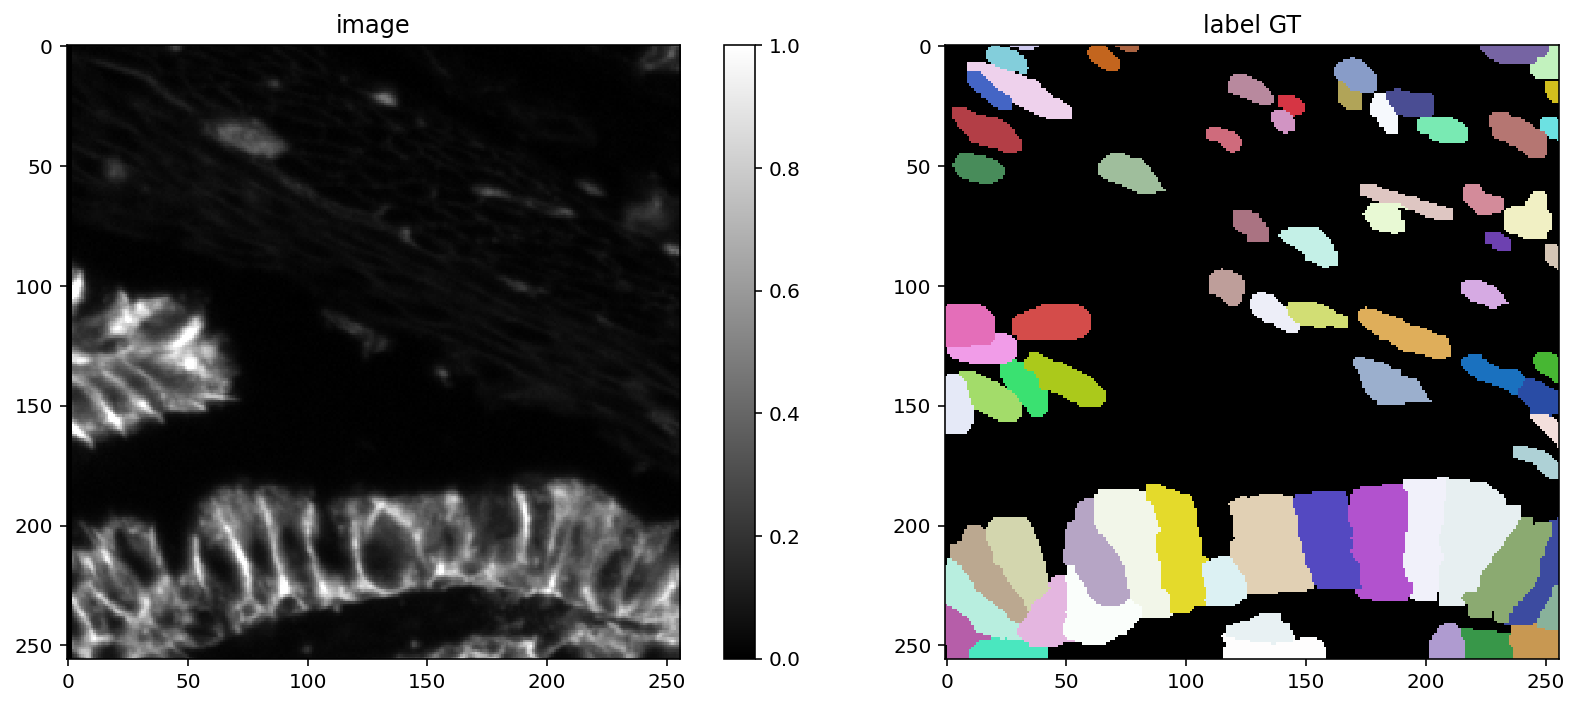

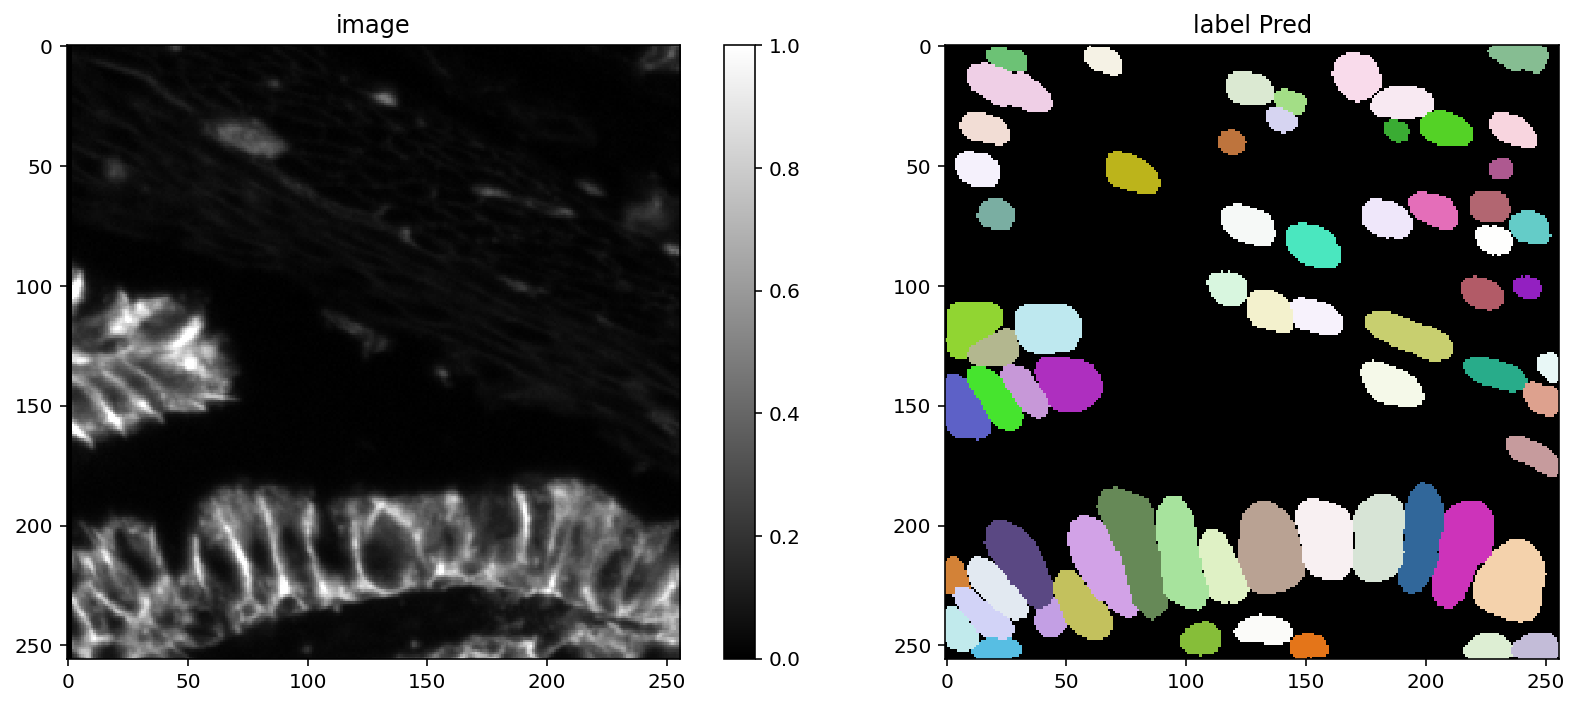

In [16]:
index = np.random.randint(0, len(X_val))

plot_img_label(X_val[index][..., 1].astype('float'),
               y_val[index], lbl_title="label GT")

plot_img_label(X_val[index][..., 1].astype('float'),
               y_val_pred[index], lbl_title="label Pred")

In [17]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(y_val, y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [03:46<00:00, 25.20s/it]


In [18]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=28560, tp=248116, fn=67077, precision=0.8967745666411253, recall=0.787187532718049, accuracy=0.7217857007793387, f1=0.838415257430276, n_true=315193, n_pred=276676, mean_true_score=0.6189557056281145, mean_matched_score=0.7862874853860384, panoptic_quality=0.6592354244741397, by_image=False)

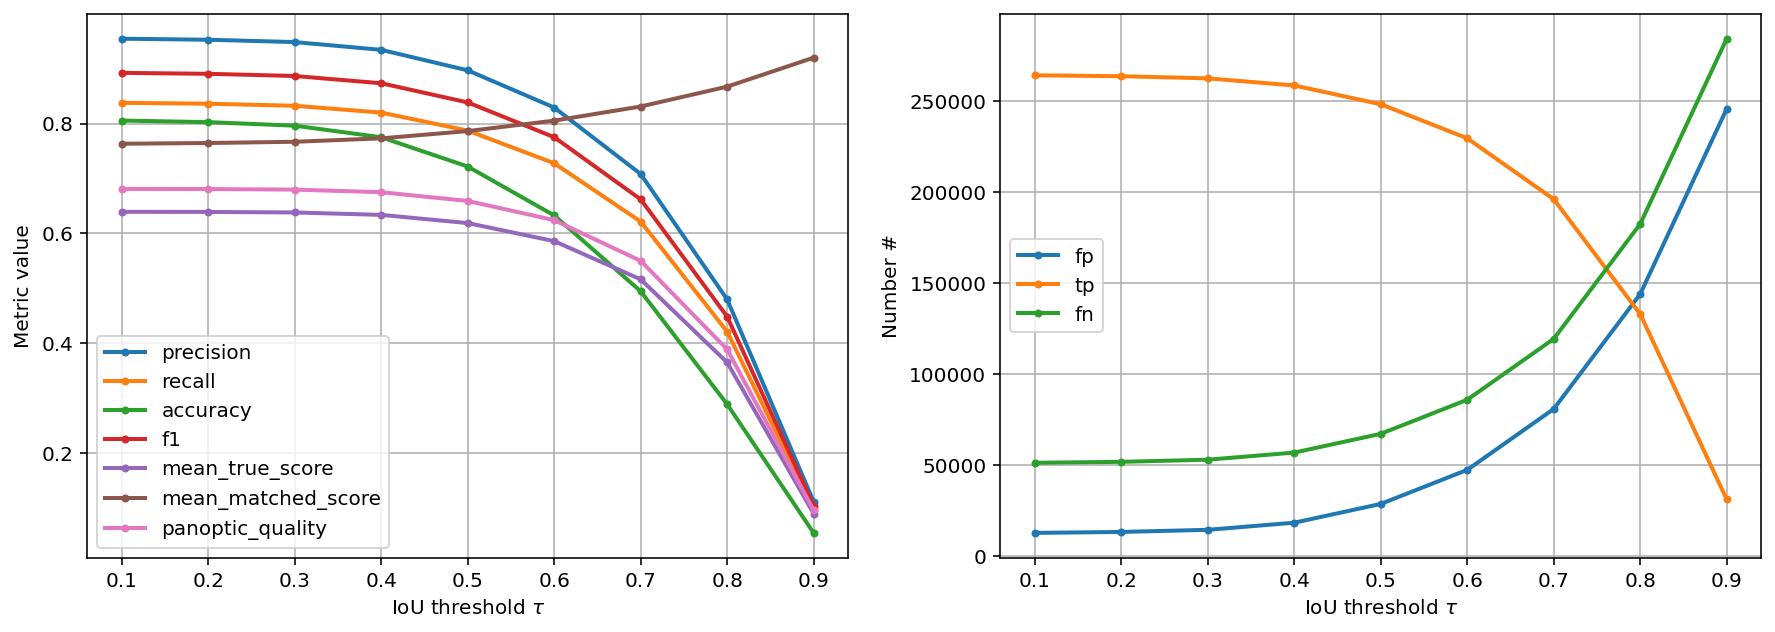

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

## Evaluate on test data

In [20]:
import timeit

start = timeit.default_timer()

y_test_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
               for x in tqdm(X_test)]

print('Predicted on %s images in %s seconds' %
      (len(y_test_pred), timeit.default_timer() - start))

100%|██████████| 1256/1256 [02:28<00:00,  8.47it/s]

Predicted on 1256 images in 148.35313658602536 seconds


In [21]:
y_test_pred_out = [np.expand_dims(np.expand_dims(y, axis=0), axis=-1) for y in y_test_pred]

y_test_pred_out = np.concatenate(y_test_pred_out, axis=0)
np.savez(TEST_PRED_DATA_FILE, y_test_pred_out)
print(TEST_PRED_DATA_FILE, 'saved!')

/data/users/willgraf/mesmer_retrain/20201018_multiplex_seed_3_test_pred.npz saved!
